Tutorial pubished by UNidata, makers of Siphon, here: https://www.youtube.com/watch?v=uZIC8nAxSzY

In [131]:
#%pip install netCDF4 -q
#%pip install siphon -q
#%pip install metpy -q

In [132]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.feature import ShapelyFeature
from metpy.units import units

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd

from datetime import datetime, timedelta
from netCDF4 import num2date
from siphon.catalog import TDSCatalog

In [133]:
geojson_path = '/workspace/notebooks/sandbox/data/input-data/dissolved-boundaries.geojson'
gdf = gpd.read_file(geojson_path)
bbox = gdf.total_bounds  # Returns [minx, miny, maxx, maxy]

wa_bbox = [110, -37.0, 131.0, -11]
print("Bounding Box:", bbox)
print("Bounding Box for WA:", wa_bbox)

Bounding Box: [116.2601213  -29.30738472 116.38758624 -29.22023779]
Bounding Box for WA: [110, -37.0, 131.0, -11]


In [134]:
best_gfs = TDSCatalog('http://thredds.ucar.edu/thredds/catalog/grib/NCEP/GFS/'
                      'Global_0p25deg/catalog.xml?dataset=grib/NCEP/GFS/Global_0p25deg/Best')

In [135]:
print(list(best_gfs.datasets))

['Best GFS Quarter Degree Forecast Time Series']


In [136]:
# the actual dataset from best_gfs, then netCDF subset service. This isn't downloading data, just metadata
ncss = best_gfs.datasets[0].subset()

#see all available variables -there's a lot.

#ncss.variables

In [137]:
query = ncss.query()
query.lonlat_box(north=wa_bbox[3], south=wa_bbox[1], east=wa_bbox[2], west=wa_bbox[0])

#want netDFC4 return
query.accept('netCDF4')

#variables we want
query.variables('Geopotential_height_isobaric', 'Temperature_surface','Precipitation_rate_surface')

query.vertical_level(50000)

now=datetime.utcnow()

#this is going to get present time to one day in the future - so a 24 hour forecast.
query.time_range(now, now + timedelta(days=1))

var=Temperature_surface&var=Geopotential_height_isobaric&var=Precipitation_rate_surface&time_start=2024-03-19T01%3A27%3A36.685171&time_end=2024-03-20T01%3A27%3A36.685171&west=110&east=131.0&south=-37.0&north=-11&accept=netCDF4&vertCoord=50000

In [138]:
data = ncss.get_data(query)
print(list(data.variables))

['reftime', 'latitude', 'time', 'isobaric', 'longitude', 'Precipitation_rate_surface', 'Temperature_surface', 'Geopotential_height_isobaric', 'LatLon_721X1440-0p13S-180p00E-2']


### Get pressure changes over 24 hour period:

In [139]:
height_var = data['Geopotential_height_isobaric']
time_var = data['time']
lat_var = data['latitude']
lon_var = data['longitude']

#squeeze gets rid of any 1-sized dimensions. [:] is an empty slice.
height_vals = height_var[:].squeeze()

lat_vals = lat_var[:].squeeze()
lon_vals = lon_var[:].squeeze()

# because of how netCDF store time, you have to use time to date conversion
time_vals = num2date(time_var[:].squeeze(), time_var.units)

# 1d lat an lon vals to a 2d grid to do actual plotting. We can do this using numpy meshgrid
lon_2d, lat_2d = np.meshgrid(lon_vals, lat_vals)

Text(0.5, 1.0, '24 hour GFS 500 hPa Height Change over Western Australia')

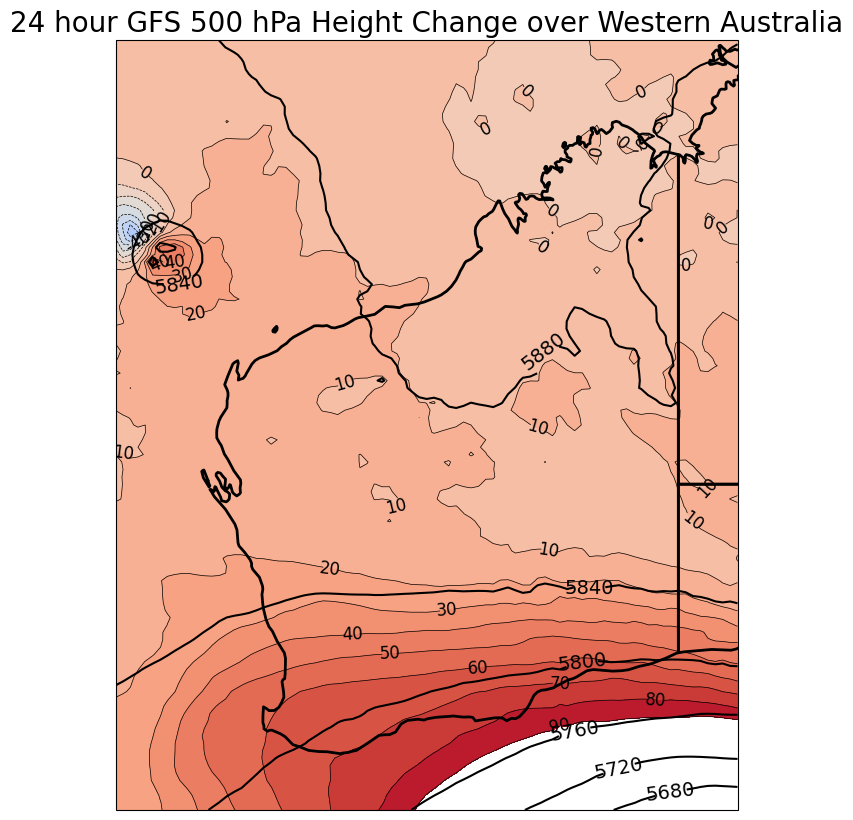

In [140]:
crs = ccrs.PlateCarree()

# boilerplate to set up a basic map
fig = plt.figure(figsize=(13, 10))
ax = fig.add_subplot(1, 1, 1, projection=crs)
ax.set_extent([wa_bbox[0], wa_bbox[2], wa_bbox[1], wa_bbox[3]], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.75)
ax.add_feature(cfeature.STATES, linewidth=2)

# add features to the map
#add height contours. height_vals indexes are time, x and y
c_height = ax.contour(lon_2d, lat_2d, height_vals[0,:,:], colors='black', linewidths=1.5, linestyles='solid', transform=ccrs.PlateCarree())

#calculate 'falls' by subtracting height at last timestep from height at first timestep. Will give us change over that interval.

falls = height_vals[-1, : :] - height_vals[0, :, :]

# add falls to map
c_falls = ax.contour(lon_2d, lat_2d, falls, colors='black', linewidths=0.5, transform=ccrs.PlateCarree(), levels = np.arange(-150, 100, 10))

# filled contours
cf_falls = ax.contourf(lon_2d, lat_2d, falls, transform=ccrs.PlateCarree(), levels = np.arange(-150, 100, 10), cmap='coolwarm')

#add contour labels
ax.clabel(c_height, fontsize=14, inline=1, inline_spacing=1, fmt='%i', rightside_up=True)
ax.clabel(c_falls, fontsize=12, inline=1, inline_spacing=1, fmt='%i', rightside_up=True)
ax.set_title('24 hour GFS 500 hPa Height Change over Western Australia', fontsize='20')

## Get maximum temp over next 24 hours:

In [155]:
temp_var = data['Temperature_surface']
temp_vals = temp_var[:].squeeze()
temp_vals = temp_vals - 273.15 #convert from kelvin to celcius

temp_2d = temp_vals[0, :, :]  # This selects the first time step and all lat/lon values
temp_2d


masked_array(
  data=[[28.305634, 28.205658, 28.005646, ..., 29.205658, 29.205658,
         29.205658],
        [28.305634, 28.205658, 28.105652, ..., 29.205658, 29.305634,
         29.205658],
        [28.305634, 28.205658, 28.105652, ..., 30.205658, 30.005646,
         29.205658],
        ...,
        [18.805634, 18.805634, 18.605652, ..., 17.805634, 17.805634,
         18.005646],
        [18.505646, 18.40564 , 18.305634, ..., 17.605652, 17.605652,
         17.605652],
        [18.40564 , 18.305634, 18.205658, ..., 17.505646, 17.505646,
         17.605652]],
  mask=False,
  fill_value=1e+20,
  dtype=float32)

Text(0.5, 1.0, 'Temperature forecast (°C) for 20th March 2024')

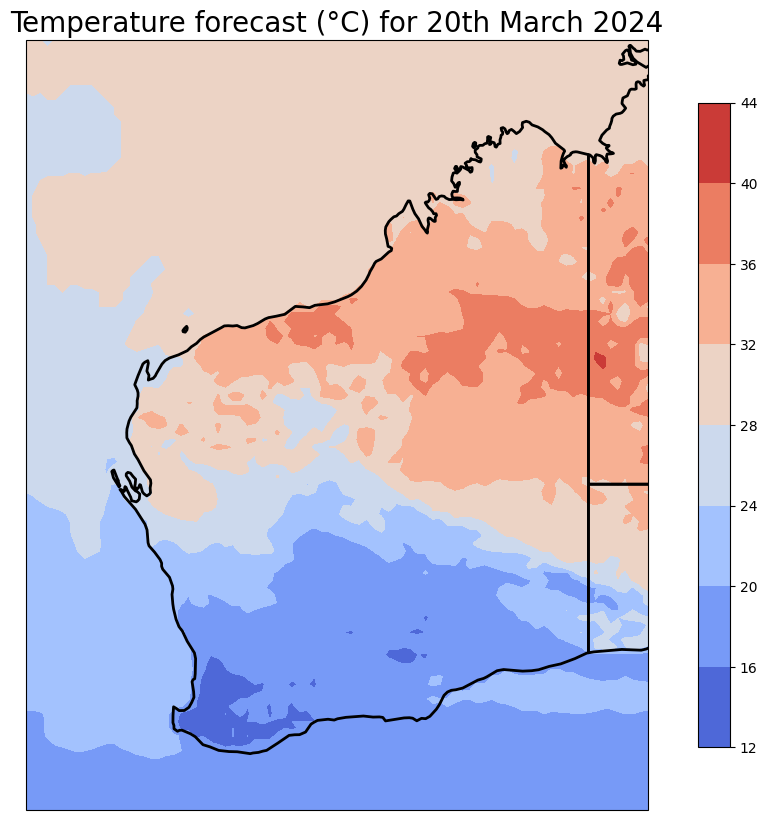

In [160]:
# boilerplate to set up a basic map
fig = plt.figure(figsize=(13, 10))
ax = fig.add_subplot(1, 1, 1, projection=crs)
ax.set_extent([wa_bbox[0], wa_bbox[2], wa_bbox[1], wa_bbox[3]], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.75)
ax.add_feature(cfeature.STATES, linewidth=2)

# Contour temperature at each lat/long
cf = ax.contourf(lon_2d, lat_2d, temp_2d, transform=ccrs.PlateCarree(),
                 cmap='coolwarm')

# Plot a colorbar to show temperature and reduce the size of it
plt.colorbar(cf, ax=ax, fraction=0.032)

# Make a title with the time value
ax.set_title(u'Temperature forecast (\u00b0C) for 20th March 2024',
             fontsize=20)